# Support vector machines

In [11]:
# import libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, mutual_info_regression

from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn import model_selection

from sklearn.impute import KNNImputer

## Data pre-processing

In [12]:
# load training data

# load data from csv file
df_train_features = pd.read_csv ('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

# Load test data
df_test_features = pd.read_csv ('test_features.csv')

 ### Histogram of the output labels 

We should check for class imbalance.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000204D4E64978>,
      dtype=object)

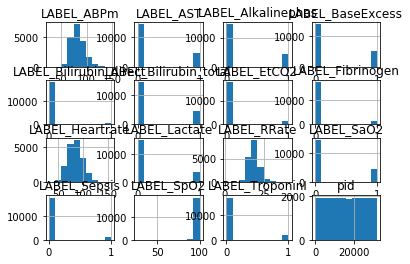

In [13]:
df_train_labels.hist()

# with PdfPages("./Results/Labels_histogram.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

One can see the class imbalance problem here. Other observations:
  * Heartrate, RRate, ABPm,  distribution is similar to a normal distribution
  * SpO2 is like a censored normal distribution. 
  * For all of the other features, class imbalance is an obvious problem.

A basic strategy that could be used here: Upsample both classes! Do the upsampling efficiently, not just replicating the datapoints

### Train Data pre-processing

       pid  Time    Age  EtCO2    PTT    BUN  Lactate  Temp   Hgb  HCO3  ...  \
min      1     1   15.0   10.0   12.5    1.0      0.2  21.0   3.3   0.0  ...   
max  31658   315  100.0  100.0  250.0  268.0     31.0  42.0  23.8  50.0  ...   

     Alkalinephos   SpO2  Bilirubin_direct  Chloride   Hct  Heartrate  \
min          12.0   20.0              0.01      66.0   9.4       23.0   
max        3833.0  100.0             21.20     141.0  63.4      191.0   

     Bilirubin_total  TroponinI   ABPs    pH  
min              0.1       0.01   21.0  6.82  
max             46.5     440.00  287.0  7.78  

[2 rows x 37 columns]


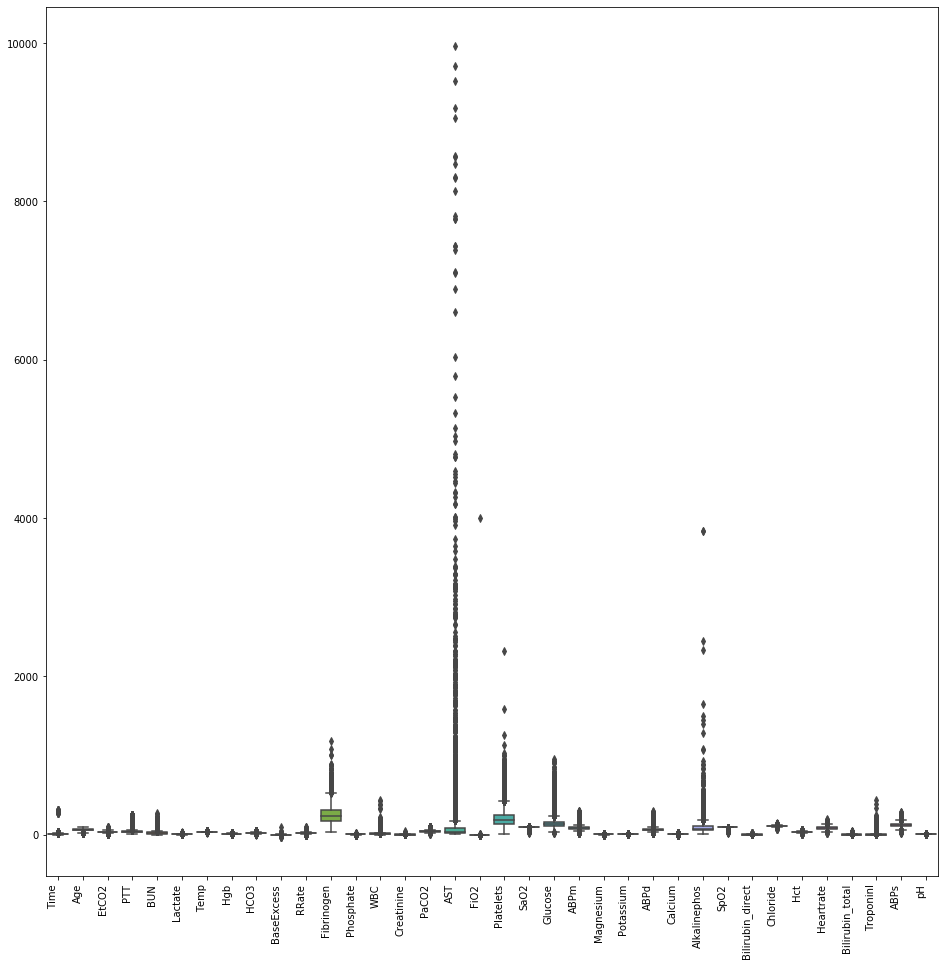

In [14]:
# data inspection: 
#############################################
# range of the provided data?
print(df_train_features.agg([min, max]))

# Boxplotting the data
# fig2, ax2 = plt.subplots()
# ax2.set_title('BUN')
# ax2.boxplot(df_train_features.iloc[:,5], notch=True)

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = df_train_features.iloc[:,1:])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# with PdfPages("./Results/Train_columns_boxplot.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

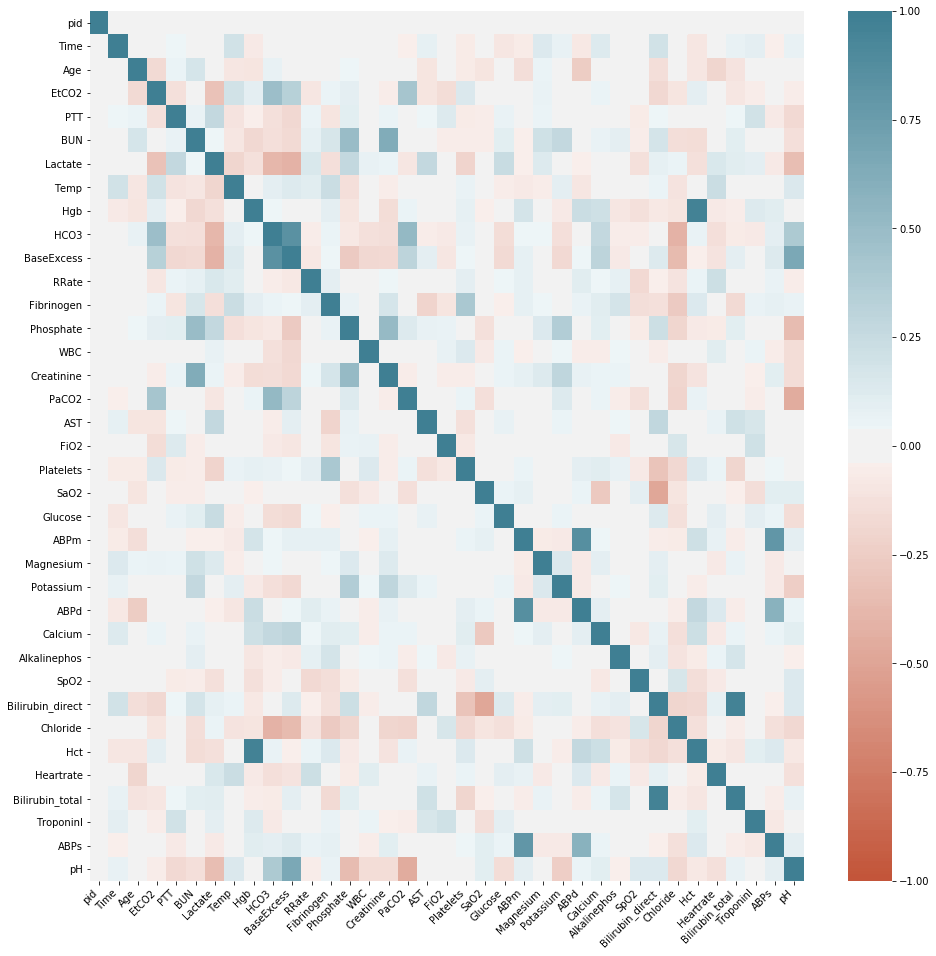

In [15]:
# calculate the correlation matrix
corr = df_train_features.corr()

# plot the heatmap
plt.figure(figsize=(16, 16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
        vmin=-1, vmax=1, center=0, 
           cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Visualizing pattern of missing values

Percentage of missing values:
pid                 0.000000
Time                0.000000
Age                 0.000000
EtCO2               0.957081
PTT                 0.954817
BUN                 0.911797
Lactate             0.952812
Temp                0.644139
Hgb                 0.902189
HCO3                0.944902
BaseExcess          0.912753
RRate               0.176165
Fibrinogen          0.989063
Phosphate           0.949153
WBC                 0.916281
Creatinine          0.921944
PaCO2               0.907682
AST                 0.974726
FiO2                0.883294
Platelets           0.920878
SaO2                0.942906
Glucose             0.793647
ABPm                0.140612
Magnesium           0.923125
Potassium           0.875437
ABPd                0.331324
Calcium             0.921778
Alkalinephos        0.974958
SpO2                0.143669
Bilirubin_direct    0.996846
Chloride            0.938944
Hct                 0.880245
Heartrate           0.122015
Bilirubin_tot

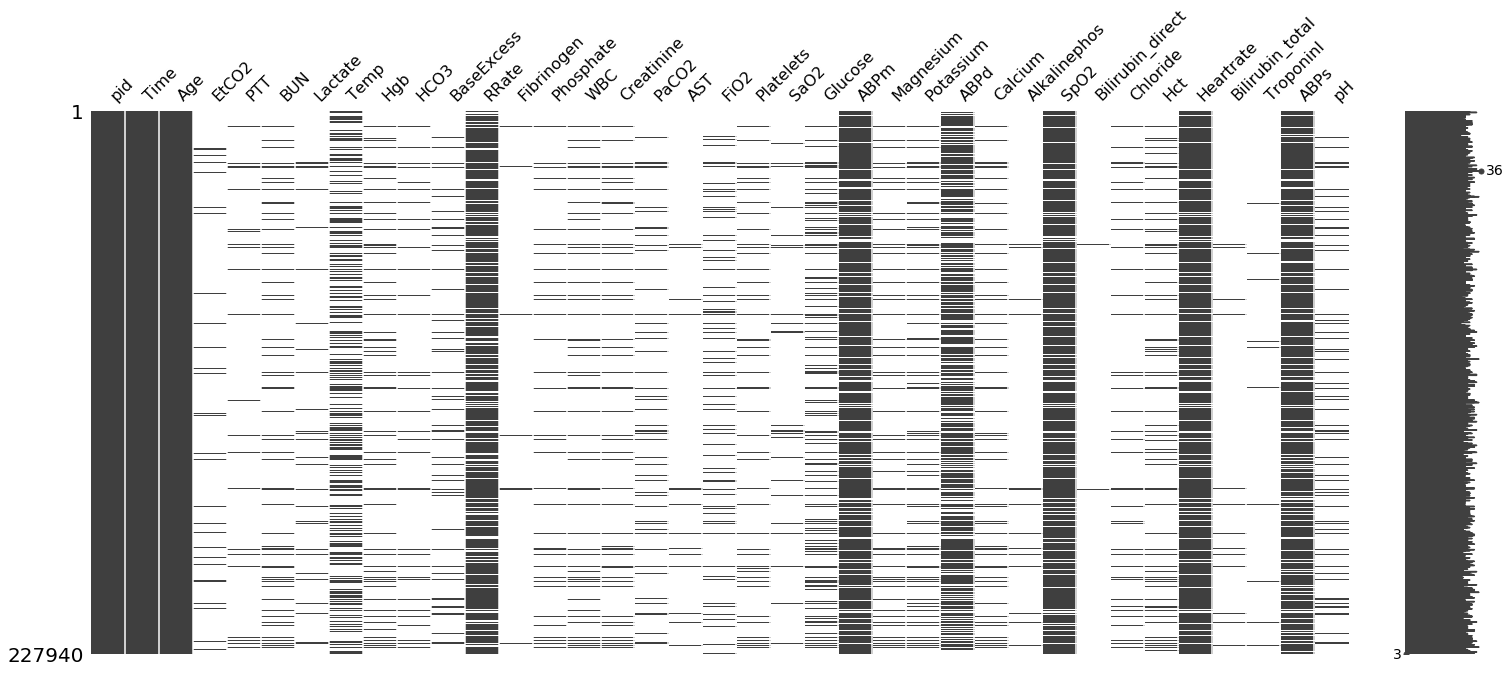

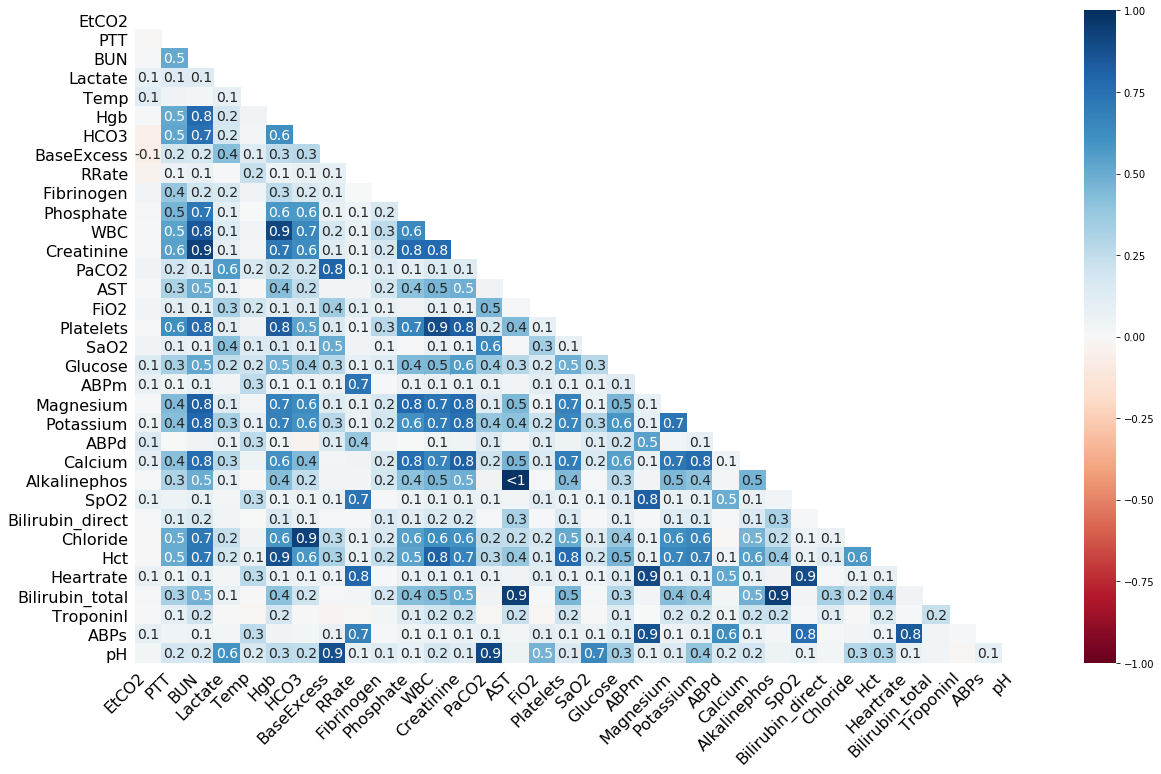

In [16]:
# how much missing data? 
print("Percentage of missing values:")
print(df_train_features.isnull().sum(axis=0) / len(df_train_features))

msno.matrix(df_train_features)

# Plotting the correlation between the missing values
msno.heatmap(df_train_features)

### Train data pre-processing

In [18]:
# impute missing data points
#imp = SimpleImputer(strategy="mean")
imputer = KNNImputer(n_neighbors = 10)
df_train_agg_features = df_train_features.groupby('pid').agg([np.min, np.max, np.mean])
df_train_agg_imputed_features = imputer.fit_transform(df_train_agg_features)
#print(df_train_agg_imputed_features)

In [19]:
# scale the data
min_max_scaler = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = min_max_scaler.fit_transform(df_train_agg_imputed_features)

In [20]:
# REARRANGE THE LABELS, TO MATCH THE REARRANGED FEATURES
# df_train_labels_sorted = df_train_labels.sort_values(by = 'pid')
# print(df_train_labels_sorted)

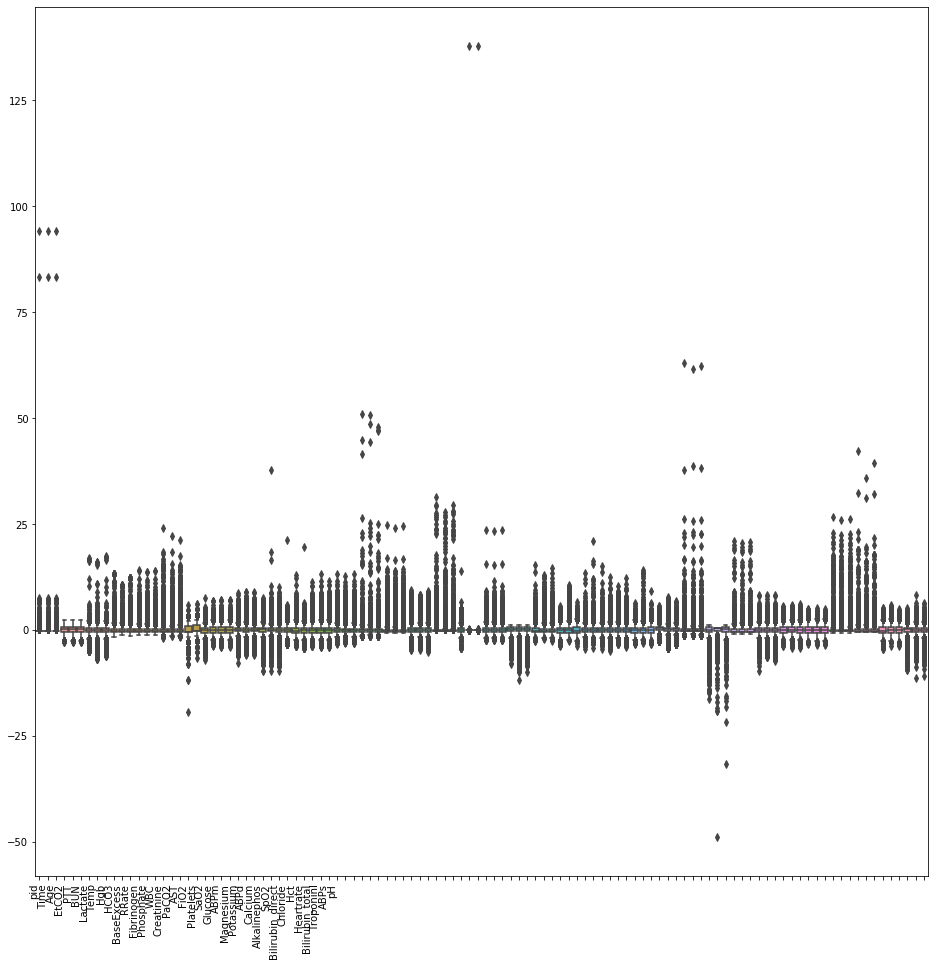

In [21]:
# Visualizing the training data after imputing and aggregating

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = pd.DataFrame(data_train_scaled))
ax.set_xticklabels(
    list(df_train_features),
    rotation=90,
    horizontalalignment='right'
);

In [22]:
# What is the correlation between the 
pd.DataFrame(data_train_scaled).corrwith(other = pd.DataFrame(df_train_agg_imputed_features), method = "spearman").transpose()

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
103    1.0
104    1.0
105    1.0
106    1.0
107    1.0
Length: 108, dtype: float64

### PCA plot 

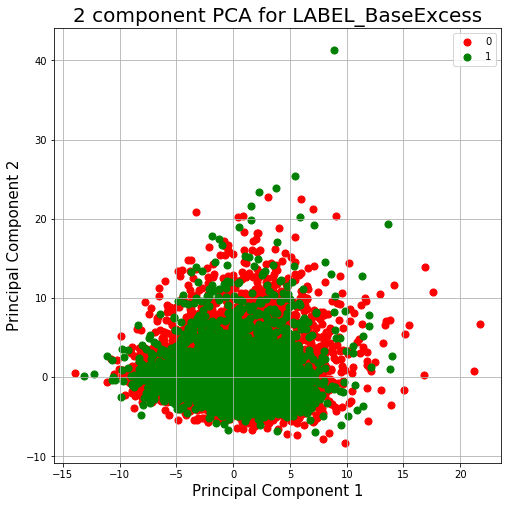

In [23]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(data_train_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_train_labels[['LABEL_BaseExcess']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA for LABEL_BaseExcess', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['LABEL_BaseExcess'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Test Data pre-processing

In [24]:
# data inspection: 
#############################################
# range of the provided data?
print(df_test_features.agg([min, max]))

# how much missing data? 
print("number of missing values:")
print(df_test_features.isnull().sum(axis=0))

       pid  Time    Age  EtCO2    PTT    BUN  Lactate  Temp   Hgb  HCO3  ...  \
min      0     1   16.0   10.0   18.1    1.0      0.3  27.0   2.3   0.0  ...   
max  31655   293  100.0  100.0  249.9  205.0     23.3  42.0  23.8  49.0  ...   

     Alkalinephos   SpO2  Bilirubin_direct  Chloride   Hct  Heartrate  \
min          11.0   22.0              0.01      74.0   9.1       21.0   
max        2121.0  100.0             21.00     145.0  71.7      184.0   

     Bilirubin_total  TroponinI   ABPs    pH  
min              0.1       0.01   28.0  6.62  
max             46.4     271.60  281.0  7.69  

[2 rows x 37 columns]
number of missing values:
pid                      0
Time                     0
Age                      0
EtCO2               145440
PTT                 145115
BUN                 138520
Lactate             144692
Temp                 97813
Hgb                 137096
HCO3                143546
BaseExcess          138730
RRate                26669
Fibrinogen          15031

In [25]:
# # aggregate data for each pid
# df_test_aggregate_features = df_test_features.groupby('pid').agg('median')

#print(df_test_aggregate_features)

# # collect all test pids
test_pids = list(set(df_test_features.pid))
df_test_agg_features = df_test_features.groupby('pid').agg([np.min, np.max, np.mean])

In [26]:
# impute missing data points
# should we impute it with the same imputer that we've used for train?

imputer = KNNImputer(n_neighbors=10)
df_test_agg_imputed_features = imputer.fit_transform(df_test_agg_features)

In [27]:
# scale test data
min_max_scaler = preprocessing.StandardScaler()
data_test_scaled = min_max_scaler.fit_transform(df_test_agg_imputed_features)

In [28]:
pd.DataFrame(data_train_scaled).to_csv("./Results/dat_train_scaled.csv")
pd.DataFrame(data_test_scaled).to_csv("./Results/dat_test_scaled.csv")

## Fit a model & Predict

### predict with support vector machine classification and use probabilities

In [29]:
# first for the labels that have an output [0,1]

columns_1 = [test_pids]

for i in range(1, 12):
   
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param=20)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    test_features = transformer.transform(data_test_scaled)

    
    #clf = BaggingClassifier(SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True, C = 10))
    clf = SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True, C = 10)
    
    #parameters = {'C':np.linspace(0.1,10,20)}
#     clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 4,
#                                        refit = True, scoring = 'roc_auc', verbose = 1, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
    #print(clf.best_params_)
    # compute probabilites as opposed to predictions
    #dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    
    distance_hyperplane = clf.decision_function(test_features)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)

    
    distance_hyperplace_train = clf.decision_function(train_features)
    probability = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability)):
        if distance_hyperplace_train[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
    
    tmp = roc_auc_score(y_score= probability, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    

[LibSVM]

KeyboardInterrupt: 

In [43]:
# labels that have a real value
columns_2 = []

for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=20)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    test_features = transformer.transform(data_test_scaled)
    
    clf_w = SVR(kernel = 'poly', degree = 3)
    parameters = {'C':np.linspace(1,10, 3)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 2,
                                       refit = True, scoring = 'r2', verbose = 1, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    print(clf.cv_results_)
    
    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  5.5min finished


{'mean_fit_time': array([ 27.36722064, 131.17642152, 198.22450548]), 'std_fit_time': array([ 2.16874414,  8.80362178, 12.76347726]), 'mean_score_time': array([1.81145936, 1.80404943, 1.24757493]), 'std_score_time': array([0.01388903, 0.13263816, 0.17673045]), 'param_C': masked_array(data=[1.0, 5.5, 10.0],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1.0}, {'C': 5.5}, {'C': 10.0}], 'split0_test_score': array([-0.17509216, -0.42448216, -0.51721979]), 'split1_test_score': array([-4.87450274, -1.6290242 , -2.23750394]), 'split2_test_score': array([-1.09512451e-01, -4.76196367e+01, -1.17087129e+02]), 'split3_test_score': array([-1.36207119, -1.09664501, -1.77038727]), 'mean_test_score': array([ -1.63029464, -12.69244703, -30.40306012]), 'std_test_score': array([ 1.9382481 , 20.16973904, 50.05102357]), 'rank_test_score': array([1, 2, 3], dtype=int32)}
R2 for feature LABEL_RRate  :  0.026540066400473905
Fitting 4 folds for each of

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  2.2min finished


{'mean_fit_time': array([17.27766716, 56.98932123, 76.07916778]), 'std_fit_time': array([ 1.89802784,  7.81090344, 10.81677409]), 'mean_score_time': array([1.81516784, 1.83532339, 1.24482948]), 'std_score_time': array([0.00900243, 0.0765121 , 0.16627473]), 'param_C': masked_array(data=[1.0, 5.5, 10.0],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1.0}, {'C': 5.5}, {'C': 10.0}], 'split0_test_score': array([-0.36411243, -0.81614337, -1.08628341]), 'split1_test_score': array([-0.05903096, -0.19201353, -0.26556818]), 'split2_test_score': array([-0.07431631, -0.16829313, -0.20195612]), 'split3_test_score': array([-0.40191924, -1.72505983, -2.23971722]), 'mean_test_score': array([-0.22484474, -0.72537746, -0.94838123]), 'std_test_score': array([0.15882686, 0.6329343 , 0.82309625]), 'rank_test_score': array([1, 2, 3], dtype=int32)}
R2 for feature LABEL_ABPm  :  0.013035679662827815
Fitting 4 folds for each of 3 candidates, totalli

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  6.9min finished


{'mean_fit_time': array([ 35.38285124, 161.02087283, 235.26078963]), 'std_fit_time': array([ 5.02682697, 14.23267587, 41.69993793]), 'mean_score_time': array([1.77589023, 1.74753654, 1.23066223]), 'std_score_time': array([0.01557095, 0.05909911, 0.14744636]), 'param_C': masked_array(data=[1.0, 5.5, 10.0],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1.0}, {'C': 5.5}, {'C': 10.0}], 'split0_test_score': array([-0.67131186, -1.21888294, -1.32003976]), 'split1_test_score': array([-3.38251438, -8.6429558 , -8.17733604]), 'split2_test_score': array([-0.09404053, -0.17167361, -0.1811899 ]), 'split3_test_score': array([-0.21235927, -0.79487701, -1.02711323]), 'mean_test_score': array([-1.09005651, -2.70709734, -2.67641973]), 'std_test_score': array([1.34099874, 3.447251  , 3.20336662]), 'rank_test_score': array([1, 3, 2], dtype=int32)}
R2 for feature LABEL_SpO2  :  0.008484212869682928
Fitting 4 folds for each of 3 candidates, tota

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.4min finished


{'mean_fit_time': array([12.2456364 , 33.51118326, 49.32312602]), 'std_fit_time': array([0.27574997, 1.61242835, 3.30078678]), 'mean_score_time': array([1.8710525 , 1.89004451, 1.46054763]), 'std_score_time': array([0.01891413, 0.01480043, 0.27495788]), 'param_C': masked_array(data=[1.0, 5.5, 10.0],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1.0}, {'C': 5.5}, {'C': 10.0}], 'split0_test_score': array([-0.10566864, -0.28710868, -0.45234388]), 'split1_test_score': array([-0.34664224, -1.9754319 , -2.10183604]), 'split2_test_score': array([-0.05116642, -0.14132585, -0.20699741]), 'split3_test_score': array([-0.12086088, -0.45733374, -0.67264573]), 'mean_test_score': array([-0.15608454, -0.71530004, -0.85845577]), 'std_test_score': array([0.11302933, 0.73608307, 0.73651964]), 'rank_test_score': array([1, 2, 3], dtype=int32)}
R2 for feature LABEL_Heartrate  :  0.030895992160811847


In [44]:
columns_final = columns_1 + columns_2

### predict with Support vector regression and then compute sigmoid function

In [ ]:
# first for the labels that have an output [0,1]

# columns_1 = [test_pids]

# for i in range(1,12):
    
#     clf = SVR(kernel = 'poly', degree = 3, max_iter = 10000)
#     clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
#     pred = clf.predict(data_test_scaled)
#     prob = np.empty(len(pred))
#     for j in range(0, len(pred)):
#         prob[j] = 1 / (1 + math.exp(-pred[j]))
#     columns_1.append(prob)
    
#     pred_train = clf.predict(data_train_scaled)
#     prob_train = np.empty(len(pred_train))
#     for j in range(0, len(pred_train)):
#         prob_train[j] = 1 / (1 + math.exp(-pred_train[j]))    
#     tmp = roc_auc_score(y_score= prob_train, y_true= df_train_labels.iloc[:,i])
#     print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)


In [ ]:
#labels that have a real value

columns_2 = []

for i in range(12, 16):
    
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=40)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    test_features = transformer.transform(data_test_scaled)


    clf_w = LinearSVR()
    parameters = {'C':np.linspace(1,10, 3)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 2,
                                       refit = True, scoring = 'r2', verbose = 1, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_)
    pred = clf.predict(test_features)
    columns_2.append(pred)
    
    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.7s remaining:    3.5s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    2.5s finished
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'mean_fit_time': array([1.59617102, 2.30886042, 2.43431294]), 'std_fit_time': array([1.07049108e-01, 3.15904617e-05, 2.95007229e-03]), 'mean_score_time': array([0.00252354, 0.00150764, 0.00124609]), 'std_score_time': array([1.06096268e-05, 3.56435776e-05, 3.80277634e-05]), 'param_C': masked_array(data=[1.0, 5.5, 10.0],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1.0}, {'C': 5.5}, {'C': 10.0}], 'split0_test_score': array([-0.01046346, -0.01211684, -0.02084947]), 'split1_test_score': array([-0.02172119, -0.02515762, -0.03035025]), 'mean_test_score': array([-0.01609232, -0.01863723, -0.02559986]), 'std_test_score': array([0.00562887, 0.00652039, 0.00475039]), 'rank_test_score': array([1, 2, 3], dtype=int32)}
R2 for feature LABEL_RRate  :  -0.010287544353303701


In [ ]:
columns_final = columns_1 + columns_2

### Random forest

In [ ]:
# Random forest Classifier
columns_1 = [test_pids]
for i in range(1, 12):
    clf = RandomForestClassifier(min_samples_leaf=2, class_weight='balanced', oob_score=False, bootstrap=False)
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    print(clf.oob_score)
    # compute probabilites as opposed to predictions
    probability = clf.apply(data_test_scaled)
    probs = [i[1] for i in probability] 
    columns_1.append(probs)
    
    
    probability = clf.predict_proba(data_train_scaled)

    probs = [i[1] for i in probability]            
    tmp = roc_auc_score(y_score= probs, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)

## Save predictions

In [45]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./Results/prediction.csv.zip', index=False, float_format='%.3f', compression='zip')

(16, 12664)


In [ ]:
result.to_csv('./Results/prediction.csv', index=False, float_format='%.3f')